# Chapter 2: Tracking number of steps (Pedometer)  

Pedometers are popular as an everyday exercise progress monitor and motivator. We look at the steps to go from 3-axis accelerometer readings to counting steps. Note that there are multiple ways to approach this problem, and what is described below is one approach that you will try to complete.

In this assignment, you are given a number of sample sensor logs and you are asked to write an algorithm to count the number of steps. The different logs correspond to different sensor placements (left pocket, right pocket, wrist), and to different walking patterns (e.g. with delays between short burst of steps). The title of each log says how many steps are present; try to get reasonably close to this number.

**NOTE: Do not aim for perfect step counting results; rather try to create an algorithm that is reasonably close to the actual number of steps. Also, keep the algorithm simple and do not over-optimize to the data** 

In [1]:
import glob
import matplotlib
import sys
import math
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, iirnotch, filtfilt, firwin, find_peaks

# enable zooming into graphs
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 5) 

## Converting a 3-axis accelerometer signal into a 1-dimensional signal

The first step is somehow converting a 3-axis accelerometer signal into a one-dimensional signal that we can use for detecting peaks. 

In [2]:
# Load in the data from one of the files. 

log_filename = 'data/Steps-Logs/D1_accel_lefthoodiepocket_3sets_15steps_delay.csv'
# log_filename = 'data/Steps-Logs/D2_accel_leftwrist_3sets_15steps_delay.csv'
# log_filename = 'data/Steps-Logs/D3_accel_leftwrist_3sets_15steps_nodelay.csv'
# log_filename = 'data/Steps-Logs/D4_accel_leftwrist_15steps_3hops_3halfspin_3touchceiling_thenshake_nodelay.csv'
# log_filename = 'data/Steps-Logs/D5_accel_leftwrist2_3sets_15steps_delay.csv'
# log_filename = 'data/Steps-Logs/D6_accel_leftwrist3_3sets_15steps_delay.csv'
# log_filename = 'data/Steps-Logs/D7_accel_righthoodiepocket_3sets_15steps_delay.csv'
# log_filename = 'data/Steps-Logs/D8_accel_righthoodiepocket_3sets_15steps_delay2.csv'
# log_filename = 'data/Steps-Logs/D9_accel_rightpocket_3sets_15steps_delay.csv'
# log_filename = 'data/Steps-Logs/D10_accel_rightpocket2_2sets_15steps_delay.csv'

raw_data = np.loadtxt(log_filename, delimiter=',', unpack=True, skiprows=0)
(accel_time, accel_x, accel_y, accel_z) = raw_data

accel_mag = np.sqrt(accel_x**2 + accel_y**2 + accel_z**2)

# start timestamps from zero (assume timestamps are in milliseconds)
c = accel_time[0]
accel_time = (accel_time - c)


### Plotting x, y, and z axes

A key challenge in step counting is dealing with differences across individuals (some have a balanced gait; others have a more imbalanced gait) and across different sensor placements. In addition, walking is not continuous, and sometimes people may stop and then continue walking. It is important to be careful about such changes since the threshold values will change depending on the current activity. If you count peaks or zero crossings while the person is stationary, there might appear to be many peaks since the signal is oscillating slightly around the mean but you should ignore these cases.

**ASSIGNMENT:** Plot acceleration readings along each of the three axes on a single graph.

<IPython.core.display.Javascript object>


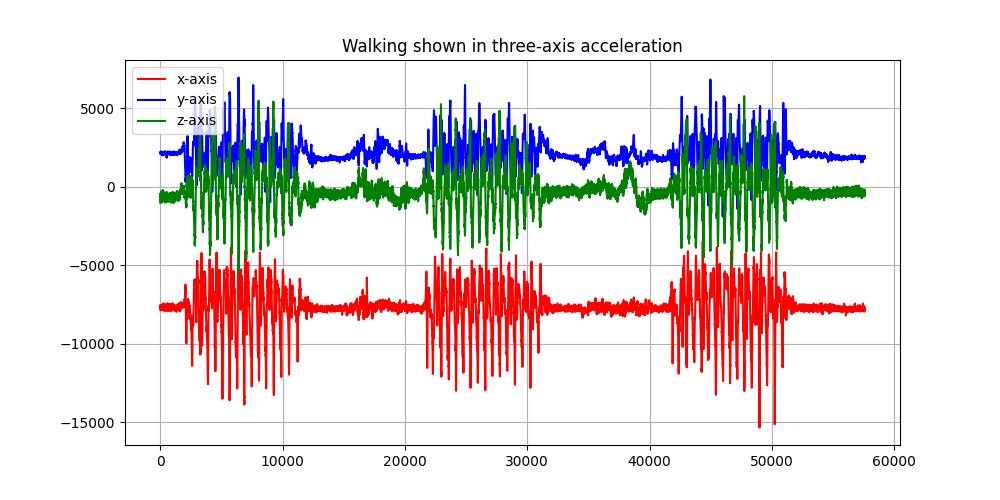

In [3]:
# FILL IN CODE: plot three-axis acceleration
plt.figure(figsize=(10,5))
plt.plot(accel_time, accel_x, 'r-',label="x-axis")
plt.plot(accel_time, accel_y, 'b-', label="y-axis")
plt.plot(accel_time, accel_z, 'g-', label="z-axis")
plt.title("Walking shown in three-axis acceleration")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

### Using magnitude rather than 3-axis signal

One issue with using the 3 axis signal directly is that the shape of the x, y, z curves depends on the orientation of the phone (or smartwatch) While the figure shows the x-axis acceleration (in red) to be the largest, this may not be the case if the x-axis is oriented along the horizontal plane. More generally, the acceleration changes as a result of the step can result in changes along all the three axes, so we need to design an orientation-independent algorithm. The easiest way to do this is to use the magnitude of the signal across all the three axes.

**ASSIGNMENT:** Plot the magnitude of acceleration

In [4]:
# FILL IN CODE: plot acceleration magnitude
plt.figure(figsize=(10,5))
plt.plot(accel_time, accel_mag, 'r-',label="magnitude")
plt.title("Walking shown in magnitude of acceleration")
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>

### Cleaning the accelerometer magnitude signal with a butterworth filter

We are now going to use a frequency domain filter called a 'butterworth filter' to remove noise (see previous notebook for further explanation of frequency-domain filtering). A Butterworth filter is a popular frequency domain 'lowpass' filter that can remove high frequency noise while only letting the low frequencies through. Since the walking signal is low frequency (only a few steps minute), this is a good approach.

**ASSIGNMENT:** Apply a Butterworth filter (as demonstrated in the previous notebook) and plot both unfiltered and filtered accelerometer signals (magnitude only).

In [5]:
# FILL IN CODE: Create and apply Butterworth filter

# Filter requirements.
order = 4
fs = 50.0  # sample rate, Hz
cutoff = 2  # desired cutoff frequency of the filter, Hz. MODIFY AS APPROPRIATE

# Create the filter.
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='low', analog=False)

# Apply the butterworth filter on the signal
filtered_signal = filtfilt(b, a, accel_mag)

<IPython.core.display.Javascript object>


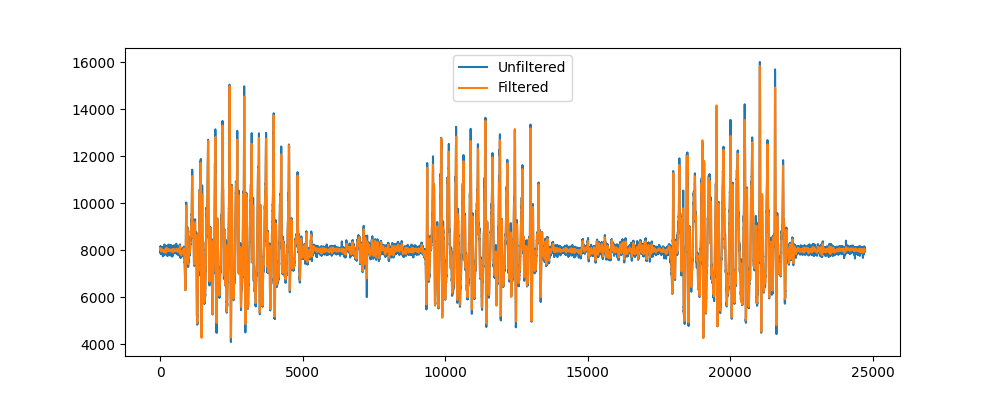

In [6]:
# FILL IN CODE: Plot original and filtered signals
# Plot original and filtered signals
plt.figure(figsize=(10,4))
plt.plot(accel_mag, label='Unfiltered')
plt.plot(filtered_signal, label='Filtered')
plt.legend()
plt.show()

# Write your step counter algorithm

Our next problem is to determine when a step occurs. From looking at the figure, you could probably come up with a few potential algorithms. Here are some steps to follow:

1. Smooth and filter out noise in your signal using the butterworth filter as above.


2. Write your step counter algorithm. You can choose any way to do this but generally it helps to think about the main characteristics of the signal that can help detect steps:

    * For example, if we could extract the peak point of each step, we can simply count the steps. 
    * We could also look for zero crossings, which means looking for crossings of the mean value in the downward (or upward) direction. 
    * To avoid false peaks from being detected, maybe you can only detect peaks within a certain min/max threshold.
    * To ensure that the peaks correspond to steps, maybe enforce a minimum peak distance between two detected "walking" peaks. 
    * Or enforce that all recognized steps come in a minimum set of 2 or 3
    * ... and many other ways.


3. Optimize your algorithm to work across many scenarios. The 12 log files correspond to different positions of the accelerometer sensor (left vs right pocket; hand vs pocket etc). Try to optimize your algorithm so it works across different datasets. Note that it is hard to get steps perfectly and there is always some error. Try to reduce error to the extent possible. Tell us what you did to minimize error.


**ASSIGNMENT:** From the filtered signal, determine the number of steps taken by the person. You can use one of the abovementioned methods or implement your own algorithm to do so. Plot the filtered signal and the detected steps.

In [7]:
# FILL IN CODE: Step counting algorithm
peaks, _ = find_peaks(filtered_signal, distance=20, height=0.1)
num_steps = len(peaks)

In [8]:
# FILL IN CODE: Plot the signal and mark the points where your algorithm detects steps
plt.figure(figsize=(10,4))
plt.plot(filtered_signal, label='Filtered Signal')
plt.plot(peaks, filtered_signal[peaks], "x", label="Steps")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

### Step counting accuracy

**ASSIGNMENT:** Complete the table below with the number of steps that you have counted for each of the data logs provided above. Example below (update):

| D# | Actual Steps | Steps Counted | Accuracy |
| --- | --- | --- | --- |
| D1 | 45 |  |  |
| D2 | 45 |  |  |
| D3 | 45 |  |  |
| D4 | 45 |  |  |
| D5 | 45 |  |  |
| D6 | 45 |  |  |
| D7 | 45 |  |  |
| D8 | 45 |  |  |
| D9 | 45 |  |  |
| D10 | 30 |  |  |

## Simulate a "real-time" step counting system

Since the next assignment will involve live step counting, let us now adapt your algorithm to a "real-time" version. The main difference is that you will be operating on data in batches since you will be reading in values from the accelerometer, buffering samples and then processing the signal. Once you process data for a window, you will move on to the next window and so on.

**ASSIGNMENT:** For the real-time step counting system, select a window of 1 second of data at a time, filter the data using a butterworth filter, and run the step detection algorithm. Plot the resulting filtered signal and the peaks that you have identified.

In [ ]:
# FILL IN CODE: Complete the real-time step counting algorithm and fill in the peak_locations array

In [ ]:
sampling_rate = 50
buffer_window_size = 100 # pick a reasonable window size, e.g. 1 second or few seconds.

peak_locations = []

for i in range(0, len(accel_mag), buffer_window_size - 1):
    
    # overlap our buffer by one sample between windows
    buffer = accel_mag[i:i+buffer_window_size]
    
    # FILL IN CODE: Filter the magnitude signal using the butterworth filter
    # Note: Butterworth filter will fail if number of samples < 18, so ignore last window if you have too few samples

    # FILL IN CODE: Run your step detection algorithm on the window.
    
print("Found {} peaks".format(len(peak_locations)))   

In [ ]:
# FILL IN CODE: Plot the signal and mark the points where your algorithm detects steps

### Real-time step counting accuracy

**ASSIGNMENT:** Complete the table below with the number of steps that you have counted for each of the data logs provided above. Example below (update):

| D# | Actual Steps | Steps Counted | Accuracy |
| --- | --- | --- | --- |
| D1 | 45 |  |  |
| D2 | 45 |  |  |
| D3 | 45 |  |  |
| D4 | 45 |  |  |
| D5 | 45 |  |  |
| D6 | 45 |  |  |
| D7 | 45 |  |  |
| D8 | 45 |  |  |
| D9 | 45 |  |  |
| D10 | 30 |  |  |

## List contribution of individual team members

List the team members and who contributed to what aspect of the assignment. 

Member 1:

Member 2:

Member 3: